# Studying the correlation between drug-induced transcriptomic response and known targets

Data used (generated in the previous notebook):
- target_vectors.tsv (vectors representing the known targets of each drug)
- transcriptional_response_vectors.tsv (vectors representing the DEG induced by each drug)

In both matrices, the rows are chemicals and the columns are genes. The order of rows/columns is the same in both.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

import getpass
import sys
import time
from tqdm import tqdm, tqdm_notebook
import string
import warnings
warnings.filterwarnings('ignore')

from utils import (get_pearson_corr, 
                     get_cosine_correlation, 
                     get_jaccard_correlation,
                     get_pearson_corr_permutation, 
                     get_cosine_corr_permutation, 
                     get_jaccard_corr_permutation,
                     get_similarity,
                     get_similarity_permutation,
                     get_nonzero_similarity,
                     get_nonzero_similarity_permutation)

In [2]:
getpass.getuser()

'chloehart'

In [3]:
sys.version

'3.8.11 (default, Aug  6 2021, 08:56:27) \n[Clang 10.0.0 ]'

In [4]:
time.asctime()

'Thu Dec 15 19:24:36 2022'

In [5]:
databases = ['ChemPert', 'ChemPert(Pathway_dbs)', 'ChemPert(Topological_level_3)']

## Load drug-induced transcriptomic response 

In [6]:
#Get transcript data frame for each database
transcript_df = {}
for database in tqdm(databases):
    transcriptomic_responses_df = pd.read_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors.tsv',
    sep='\t',
    index_col=0,
    )
    transcriptomic_responses_df.head(4)
    transcriptomic_responses_df.shape
    transcript_df[database] = transcriptomic_responses_df.copy()

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


## Load the known targets for each drug

In [7]:
#Get target data frame for each database
target_df = {}
for database in tqdm(databases):
    if database == 'ChemPert':
        targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_' + database + '.tsv',
            sep='\t',
            index_col=0,
        )
    else:
        targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_' + database + '.csv',
            sep=',',
            index_col=0,
        )
        targets_df = targets_df.drop(list(set(targets_df.columns) \
                                      - set(transcript_df[database].columns)), axis=1)
        targets_df.to_csv('../data/target_data_frames/target_vectors_' + database + '.csv')
    target_df[database] = targets_df.copy()

100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.89s/it]


In [8]:
for database in tqdm(databases):
    assert list(target_df[database].columns) == list(transcript_df[database].columns)
    assert list(target_df[database].index) == list(transcript_df[database].index)
    

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 454.77it/s]


# Get number of nonzero values in the target data frames

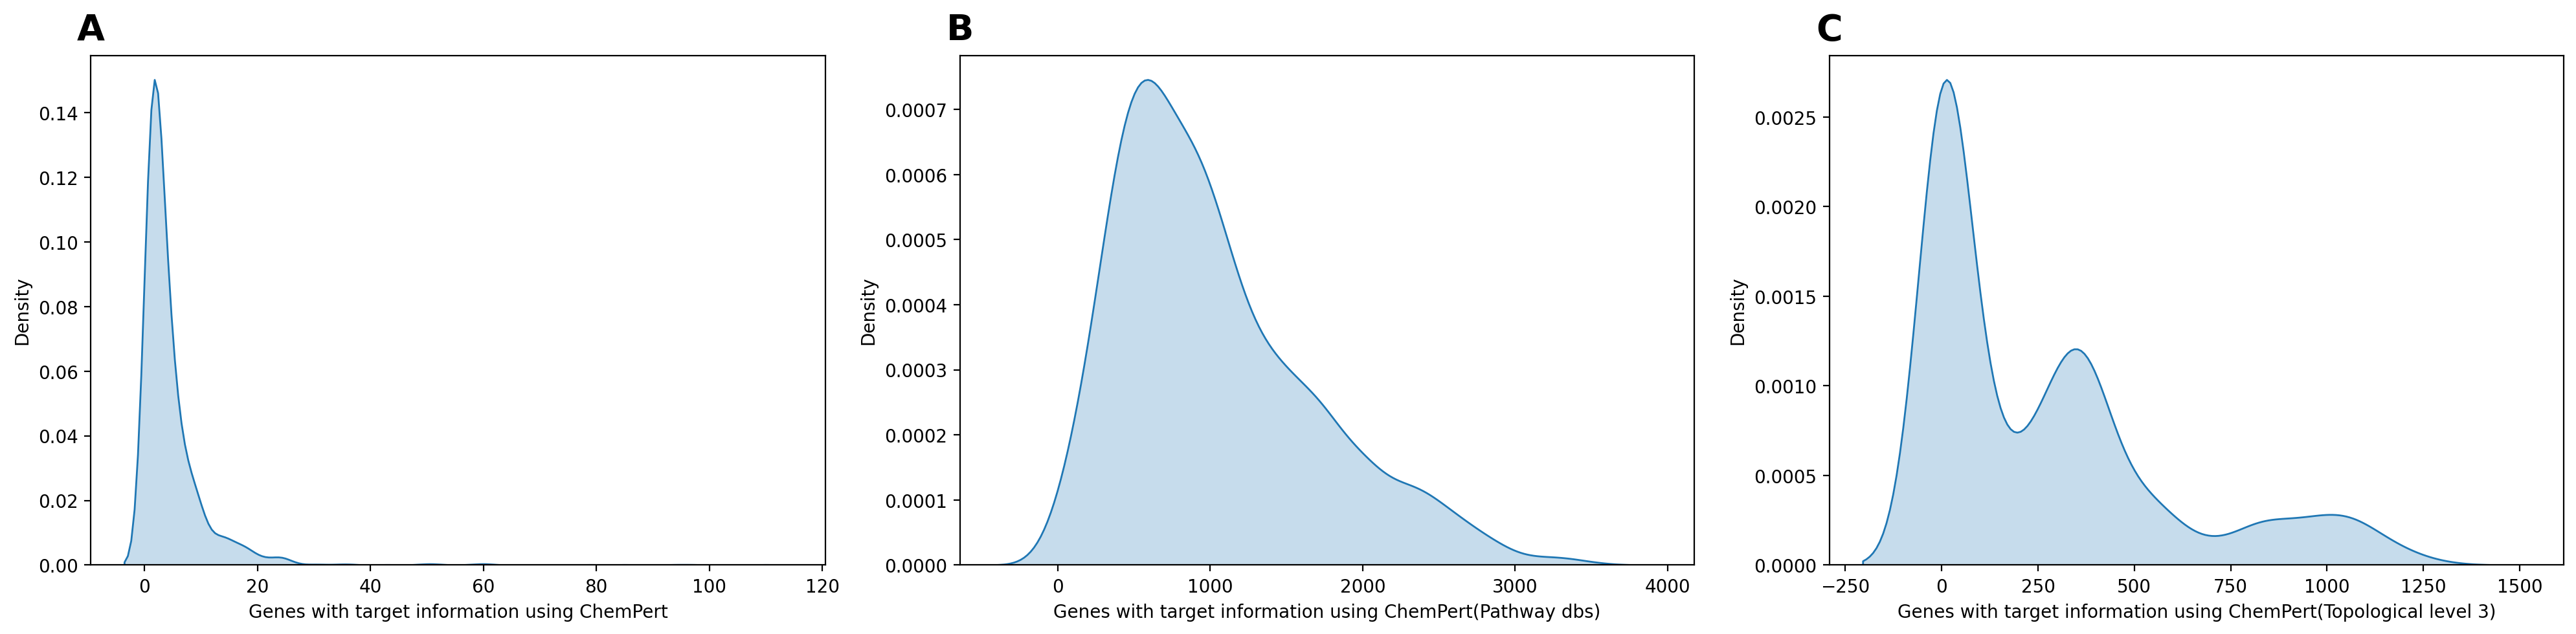

In [9]:
plt.figure(dpi=200, figsize = (20,5))
for i,database in enumerate(databases):
    #Set initial variables
    num_targets = []

    
    #Get number of nonzero targets
    for drug in target_df[database].index.values:
        num_targets.append(len(np.nonzero(list(target_df[database].loc[drug]))[0]))

    #Create plot
    plt.subplot(1, len(databases), i+1)
    sns.kdeplot(num_targets, shade=True)
    plt.xlabel('Genes with target information using ' + database.replace('_', ' '))
    plt.text(0, 1.05, string.ascii_uppercase[i],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    
plt.tight_layout()
plt.show()
        

100%|█████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


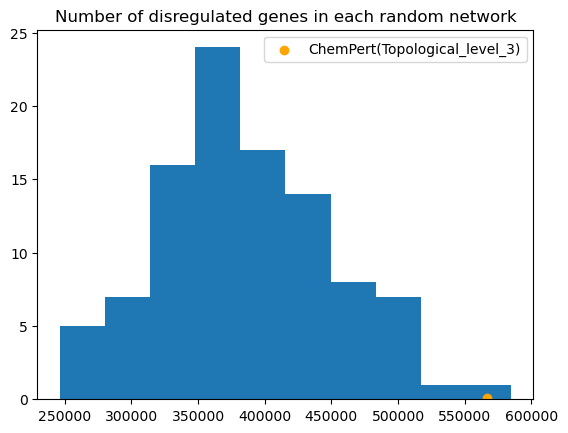

In [11]:
# Get number of nonzero values in each random network
nonzero_vals = []
for i in tqdm(range(1,101)):
    network_name = 'random_networks/random_' + str(i)
    current_target = pd.read_csv('../test_data/target_data_frames/' + network_name + '.csv', index_col=0)
    nonzero_vals.append(len(np.nonzero(current_target.to_numpy())[0]))

# Create plot
plt.hist(nonzero_vals)
plt.scatter(len(np.nonzero(target_df['ChemPert(Topological_level_3)'].to_numpy().flatten())[0]),
            .1, color='orange', label ='ChemPert(Topological_level_3)')
plt.title('Number of disregulated genes in each random network')
plt.legend()
plt.show()

# Calculate Correlation Metrics for each drug

In [12]:
from numpy import dot
from numpy.linalg import norm
from scipy.spatial.distance import jaccard
from matplotlib.lines import Line2D

In [18]:
#Set initial variables
pearson_corr_df = {}
colors = ['navy', 'cornflowerblue', 'lightsteelblue','red', 'yellowgreen', 'royalblue', 'lightpink','gold', 'black']
cosine_corr_df = {}
jaccard_corr_df = {}

#Graph pearson correlation values for each database
for i,database in enumerate(databases):
    #Get pearson correlation values
    pearson_corr_df[database] = get_pearson_corr(target_matrix=target_df[database], \
                                                transcriptomic_matrix=transcript_df[database])

    #Get Jaccard Similarity values
    jaccard_corr_df[database] = get_jaccard_correlation(
        target_matrix=target_df[database], 
        transcriptomic_matrix=transcript_df[database]
    )


# Pearson Correlation for 100 random networks

  0%|          | 0/100 [00:00<?, ?it/s]

P-value:  0.59


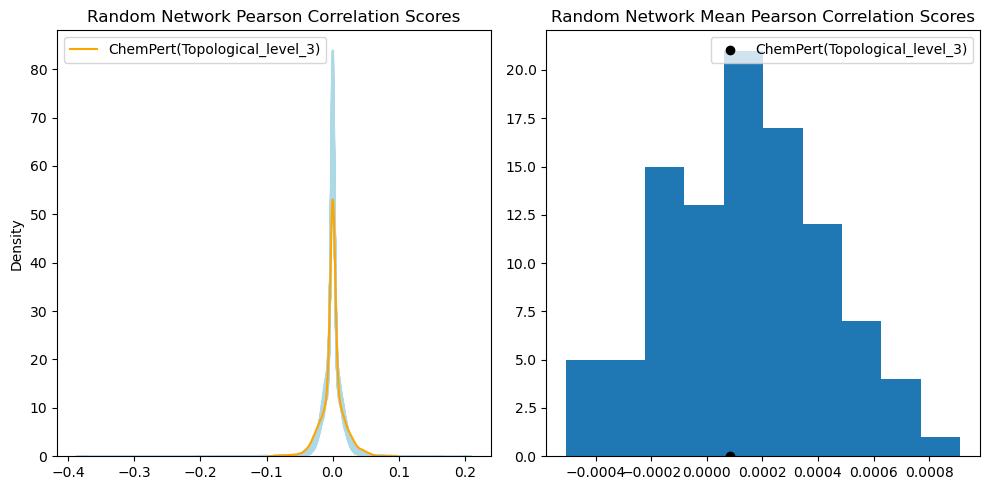

In [14]:
#Set initial variables
current_pearson_corr_df = {}
current_jaccard_corr_df = {}
p_values = []
permutation_means = []
plt.figure(figsize=(10,5))
num_random_networks = 100

#Get permutation means for each network
plt.subplot(1,2,1)
for i in tqdm_notebook(range(1, num_random_networks+1)):
    network_name = 'random_' + str(i) + '.csv'
    current_target = pd.read_csv('../test_data/target_data_frames/random_networks/' + network_name, index_col=0)
    num_compounds = current_target.shape[0]
    permutation = current_target.copy().reset_index(drop=True).corrwith(transcript_df['ChemPert'].copy()\
                                                                       .sample(frac=1).reset_index(drop=True), 
                                                                   method='pearson', 
                                                                   axis=1)
    permutation_means.append(sum(permutation)/num_compounds)
    sns.distplot(permutation, color='lightblue', hist=False)
sns.distplot(target_df['ChemPert(Topological_level_3)'].copy().corrwith(transcript_df['ChemPert'].copy(), 
                                                                        method='pearson', axis=1),
            hist=False, color='orange', label='ChemPert(Topological_level_3)')
plt.title('Random Network Pearson Correlation Scores')
plt.legend()

# Calculate p-value
original_mean = np.sum(target_df['ChemPert(Topological_level_3)'].copy()
                   .corrwith(transcript_df['ChemPert(Topological_level_3)'].copy(), 
                             method='pearson', 
                             axis=1))/num_compounds
p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_random_networks
print('P-value: ', p_value)

#Plot histogram
plt.subplot(1,2,2)
plt.hist(permutation_means)
plt.scatter(original_mean,0, 
            label='ChemPert(Topological_level_3)', 
            color='black')
plt.title('Random Network Mean Pearson Correlation Scores')
plt.legend()
plt.tight_layout()
plt.show()


### Get mean absolute value of the pearson correlation scores

  0%|          | 0/100 [00:00<?, ?it/s]

P-value:  0.01


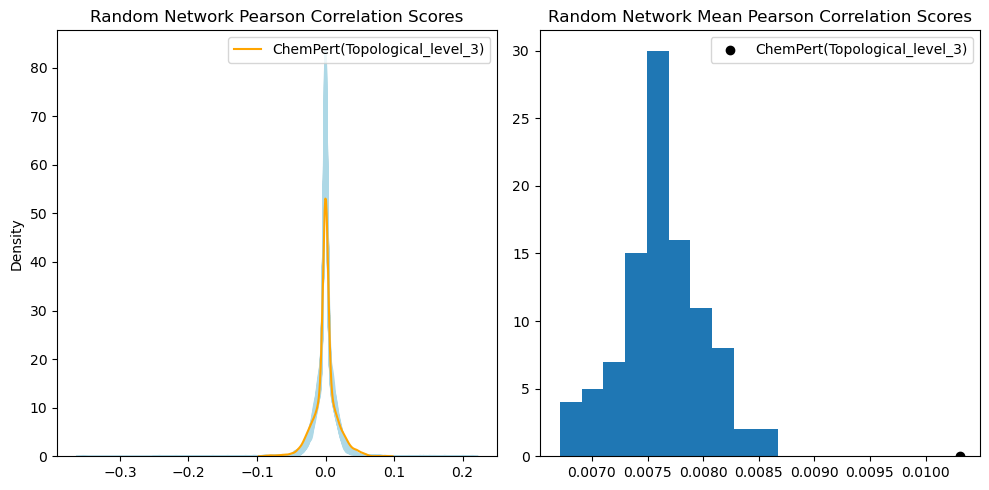

In [15]:
#Set initial variables
current_pearson_corr_df = {}
current_jaccard_corr_df = {}
p_values = []
permutation_means = []
plt.figure(figsize=(10,5))
num_random_networks = 100

#Get permutation means for each network
plt.subplot(1,2,1)
for i in tqdm_notebook(range(1, num_random_networks+1)):
    network_name = 'random_' + str(i) + '.csv'
    current_target = pd.read_csv('../test_data/target_data_frames/random_networks/' + network_name, index_col=0)
    num_compounds = current_target.shape[0]
    permutation = current_target.copy().reset_index(drop=True).corrwith(transcript_df['ChemPert'].copy()\
                                                                       .sample(frac=1).reset_index(drop=True), 
                                                                   method='pearson', 
                                                                   axis=1)
    permutation_means.append(sum(abs(permutation))/num_compounds)
    sns.distplot(permutation, color='lightblue', hist=False)
sns.distplot(target_df['ChemPert(Topological_level_3)'].copy().corrwith(transcript_df['ChemPert'].copy(), 
                                                                        method='pearson', axis=1),
            hist=False, color='orange', label='ChemPert(Topological_level_3)')
plt.title('Random Network Pearson Correlation Scores')
plt.legend()

# Calculate p-value
original_mean = np.sum(abs(target_df['ChemPert(Topological_level_3)'].copy()
                   .corrwith(transcript_df['ChemPert(Topological_level_3)'].copy(), 
                             method='pearson', 
                             axis=1)))/num_compounds
p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_random_networks
print('P-value: ', p_value)

#Plot histogram
plt.subplot(1,2,2)
plt.hist(permutation_means)
plt.scatter(original_mean,0, 
            label='ChemPert(Topological_level_3)', 
            color='black')
plt.title('Random Network Mean Pearson Correlation Scores')
plt.legend()
plt.tight_layout()
plt.show()


# Jaccard Correlation for 100 random networks

In [16]:
from scipy.spatial.distance import jaccard
def jaccard_corr(x,y):
    return 1 - jaccard(x,y)

  0%|          | 0/100 [00:00<?, ?it/s]

P-value:  0.05


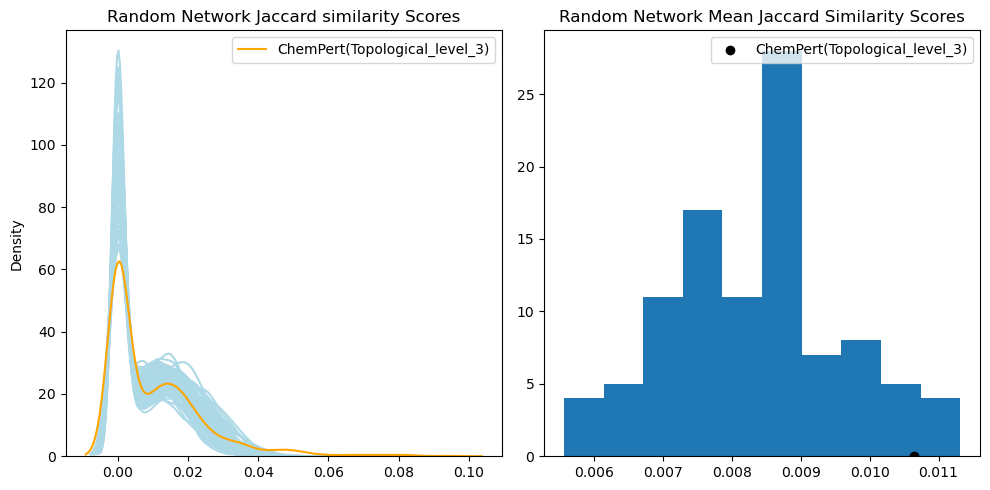

In [17]:
#Set initial variables
current_pearson_corr_df = {}
current_jaccard_corr_df = {}
p_values = []
permutation_means = []
plt.figure(figsize=(10,5))
num_random_networks = 100


#Get permutation means for each of the random networks
plt.subplot(1,2,1)
for i in tqdm_notebook(range(1,num_random_networks+1)):
    network_name = 'random_networks/random_' + str(i)
    current_target = pd.read_csv('../test_data/target_data_frames/' + network_name + '.csv', index_col=0)
    num_compounds = current_target.shape[0]
    permutation = current_target.copy().reset_index(drop=True).corrwith(transcript_df['ChemPert'].copy()\
                                                                       .sample(frac=1).reset_index(drop=True), 
                                                                   method=jaccard_corr, 
                                                                   axis=1)
    permutation_means.append(sum(permutation)/num_compounds)
    sns.distplot(permutation, color='lightblue', hist=False)
sns.distplot(target_df['ChemPert(Topological_level_3)'].copy().corrwith(transcript_df['ChemPert'].copy(), 
                                                                        method=jaccard_corr, axis=1),
            hist=False, color='orange', label='ChemPert(Topological_level_3)')
plt.title('Random Network Jaccard similarity Scores')
plt.legend()

# Calculate p-value
original_mean = np.sum(target_df['ChemPert(Topological_level_3)'].copy()
                   .corrwith(transcript_df['ChemPert(Topological_level_3)'].copy(), 
                             method=jaccard_corr, 
                             axis=1))/num_compounds
p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_random_networks
print('P-value: ', p_value)

#Plot histogram
plt.subplot(1,2,2)
plt.hist(permutation_means)
plt.scatter(original_mean,0, 
            label='ChemPert(Topological_level_3)', 
            color='black')
plt.title('Random Network Mean Jaccard Similarity Scores')
plt.legend()
plt.tight_layout()
plt.show()